In [ ]:
# Copyright © 2025 UChicago Argonne, LLC All right reserved
# Full license accessible at https://github.com/AdvancedPhotonSource/DONUT/blob/main/LICENSE

import os
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cmcrameri.cm as cmc
from skimage.measure import marching_cubes

%matplotlib inline
plt.style.use('/home/beams/B313762/stylesheet.mplstyle')

## 3D Bragg peak visualization (simulated)

In [2]:
# Parameters for the functions
sigma_x = 0.3  # Width of Gaussian in x-direction
sigma_y = 0.3  # Width of Gaussian in y-direction
scale_z = 1.0  # Scaling factor for sinc function

# Define the 3D Bragg peak function
def bragg_peak_function(x, y, z):
    """
    Generate a 3D Bragg peak from a thin film:
    - Gaussian distribution along x and y axes
    - Sinc function along z axis
    """
    gaussian_x = np.exp(-(x**2)/(2*sigma_x**2))
    gaussian_y = np.exp(-(y**2)/(2*sigma_y**2))
    sinc_z = np.sinc(z/scale_z)  # Note: NumPy's sinc is sin(πx)/(πx)
    return gaussian_x * gaussian_y * sinc_z

In [3]:
# Create coordinate arrays for 2D slices
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
z = np.linspace(-10, 10, 200)

# Create 2D meshgrids for slices
X, Y = np.meshgrid(x, y, indexing='ij')
X_xz, Z_xz = np.meshgrid(x, z, indexing='ij')
Y_yz, Z_yz = np.meshgrid(y, z, indexing='ij')

# Calculate 2D slices
xy_slice = bragg_peak_function(X, Y, 0)      # XY plane at Z=0
xz_slice = bragg_peak_function(X_xz, 0, Z_xz)  # XZ plane at Y=0
yz_slice = bragg_peak_function(0, Y_yz, Z_yz)  # YZ plane at X=0

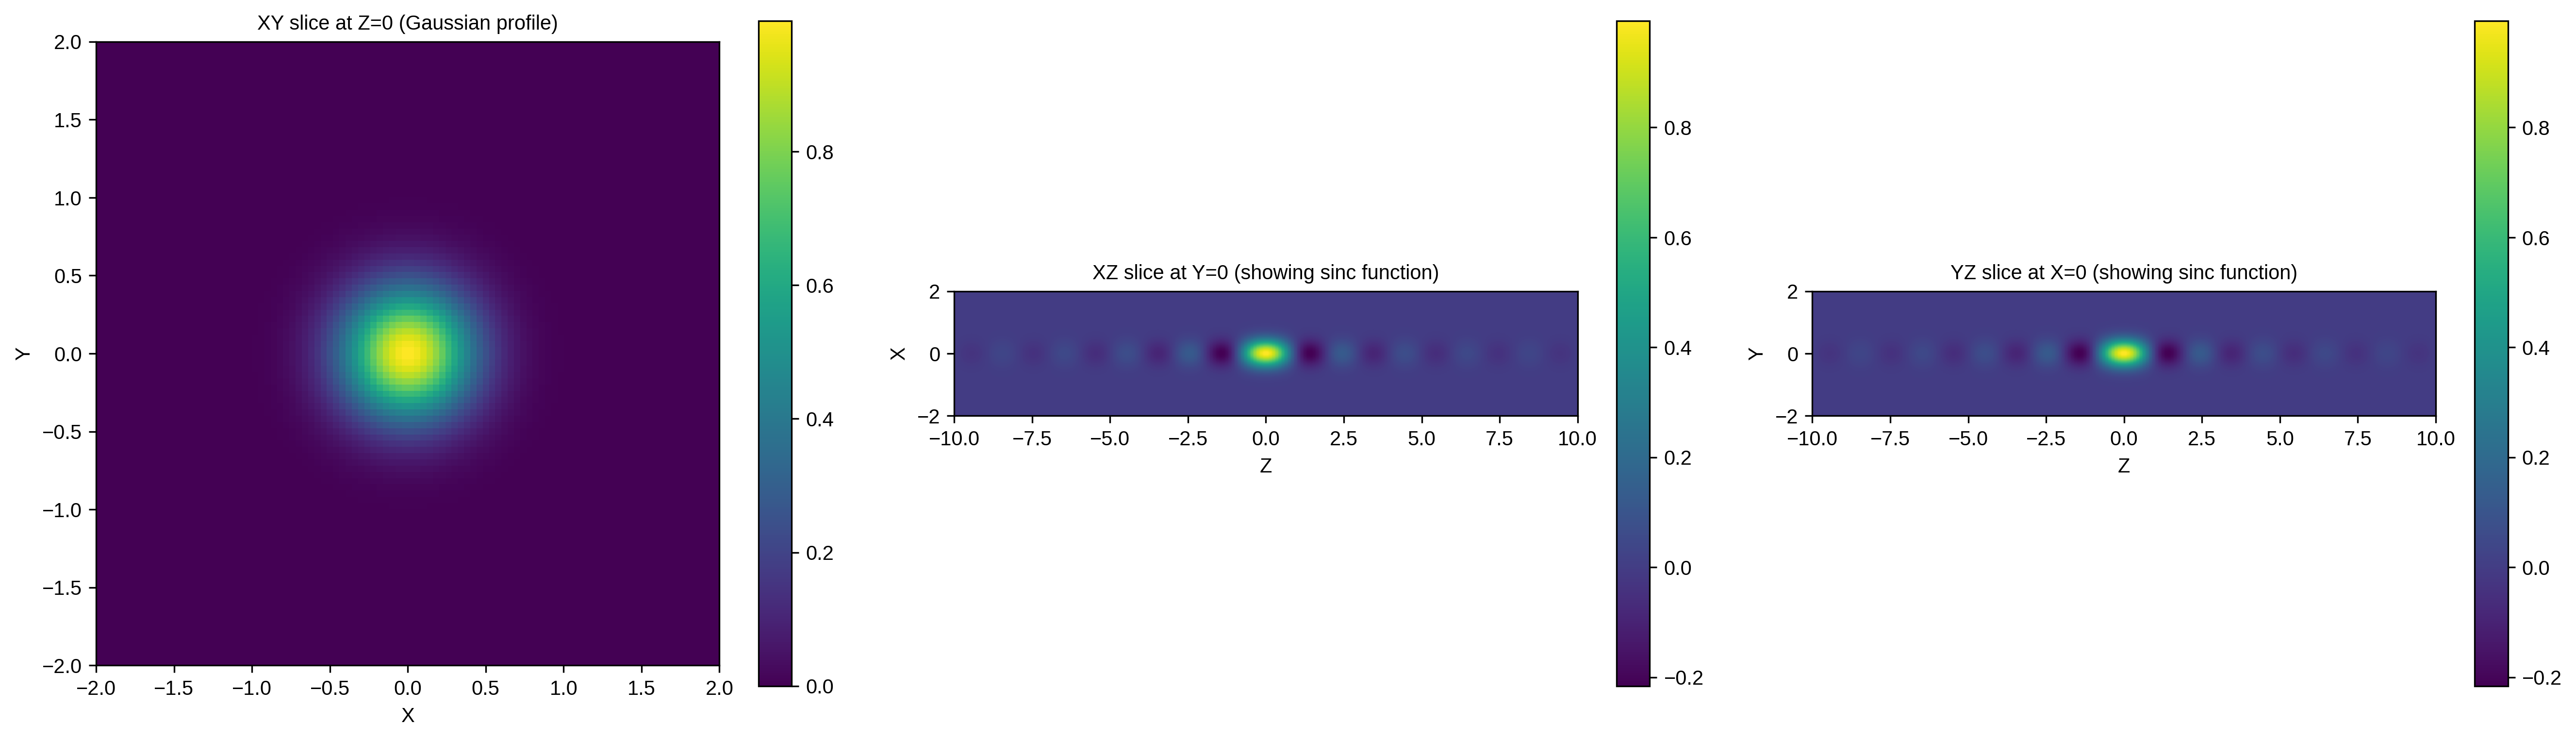

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

# Plot 2D slices
f, ax = plt.subplots(1, 3, figsize=(18, 5))

# XY slice
im0 = ax[0].imshow(xy_slice, extent=[x.min(), x.max(), y.min(), y.max()], 
               origin='lower', cmap='viridis')
ax[0].set_title('XY slice at Z=0 (Gaussian profile)')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
f.colorbar(im0, ax=ax[0])

# XZ slice
im1 = ax[1].imshow(xz_slice, extent=[z.min(), z.max(), x.min(), x.max()], 
               origin='lower', cmap='viridis')
ax[1].set_title('XZ slice at Y=0 (showing sinc function)')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('X')
f.colorbar(im1, ax=ax[1])

# YZ slice
im2 = ax[2].imshow(yz_slice, extent=[z.min(), z.max(), y.min(), y.max()], 
               origin='lower', cmap='viridis')
ax[2].set_title('YZ slice at X=0 (showing sinc function)')
ax[2].set_xlabel('Z')
ax[2].set_ylabel('Y')
f.colorbar(im2, ax=ax[2])

plt.tight_layout()

#f.savefig('bragg_peak_slices.svg', dpi=300, bbox_inches='tight', transparent=True)

In [5]:
# Create 3D grid for visualization
x_3d = np.linspace(-1.5, 1.5, 120)
y_3d = np.linspace(-1.5, 1.5, 120)  
z_3d = np.linspace(-10, 10, 400)
X_3d, Y_3d, Z_3d = np.meshgrid(x_3d, y_3d, z_3d, indexing='ij')
intensities_3d = bragg_peak_function(X_3d, Y_3d, Z_3d)

/tmp/ipykernel_2667171/3794091319.py:5: RuntimeWarning: invalid value encountered in log10
  verts, faces, _, _ = marching_cubes(np.log10(marr), step_size=1)


(120, 120, 400)


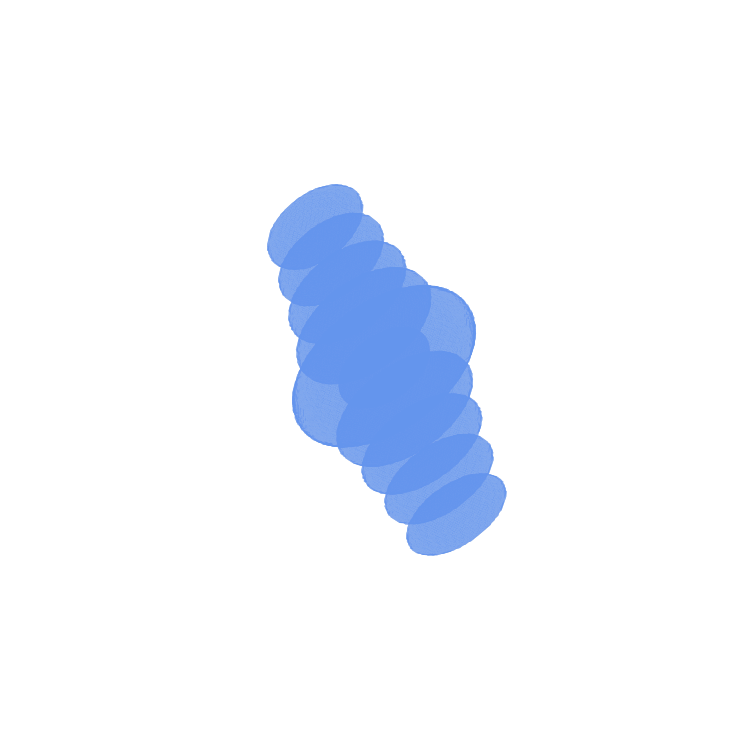

In [29]:
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
mask = intensities_3d > 0.01
print(mask.shape)
marr = np.ma.array(intensities_3d, mask=~mask)
verts, faces, _, _ = marching_cubes(np.log10(marr), step_size=1)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.7)
face_color = colors.to_rgb('cornflowerblue')
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
ax.set_xlim(0, marr.shape[0])
ax.set_ylim(0, marr.shape[1])
ax.set_zlim(0, marr.shape[2])
ax.view_init(elev=-20, azim=30, roll=-75, vertical_axis='x')
ax.set_axis_off()
fig.savefig('3d_bragg.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

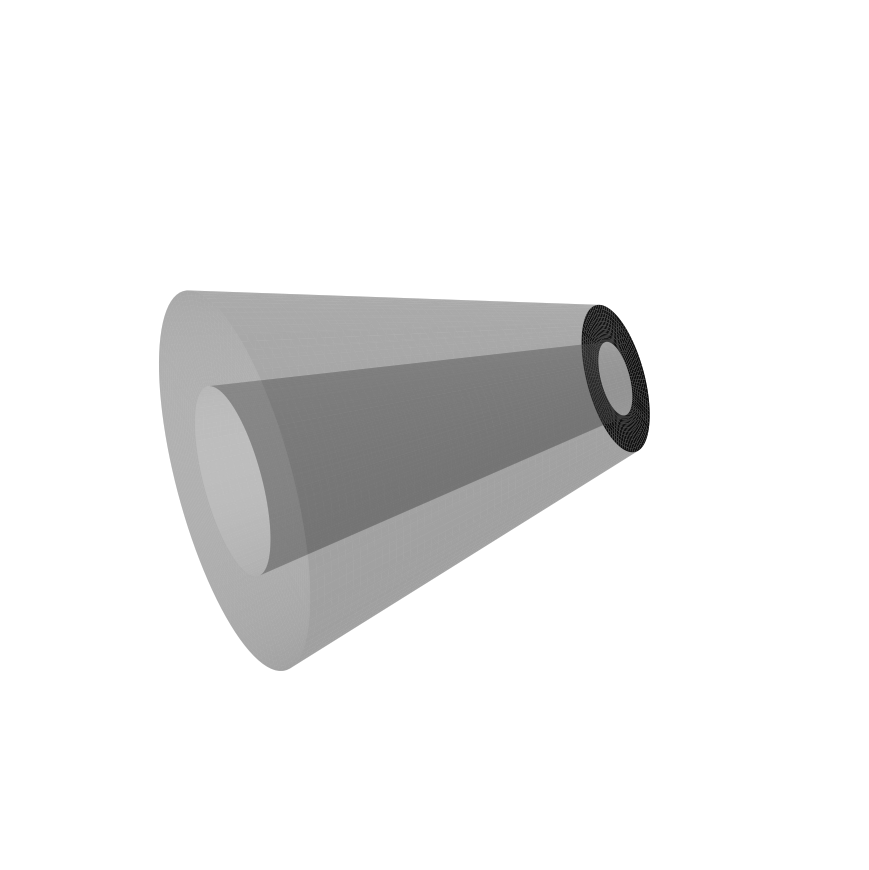

In [30]:
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
# Parameters
resolution = 100
outer_radius = 1.0  # Outer radius of the donut mask
inner_radius = 0.5  # Inner radius of the donut mask
cone_height = 2.0  # Height of the cone
cone_top_radius_factor = 0.4  # Ratio of top radius to base radius

# Create a figure
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111, projection='3d')

# Create the donut mask (at the base of the cone, z=0)
theta = np.linspace(0, 2*np.pi, resolution)
r = np.linspace(inner_radius, outer_radius, 20)
Theta, R = np.meshgrid(theta, r)
X_donut = R * np.cos(Theta)
Y_donut = R * np.sin(Theta)
Z_donut = np.zeros_like(X_donut)  # Flat disk at z=0
#Z_donut = np.ones_like(X_donut)

# Create binary mask matrix for visualization
# 1 inside the donut region (between inner and outer radius)
mask = np.ones_like(Z_donut)

# Plot the donut mask with binary color (black)
# ax.plot_surface(X_donut, Y_donut, Z_donut, facecolors=cm.binary(mask),
#                alpha=0.3, rstride=1, cstride=1)
ax.plot_surface(X_donut, Y_donut, Z_donut, color='gray', alpha=0.3, rstride=1, cstride=1)

# Create the hollow cone
theta_cone = np.linspace(0, 2*np.pi, resolution)
z_cone = np.linspace(0, cone_height, resolution//2)
Theta_cone, Z_cone = np.meshgrid(theta_cone, z_cone)

# Outer cone surface (linearly tapering from outer_radius to cone_top_radius_factor*outer_radius)
cone_top_radius = cone_top_radius_factor * outer_radius
R_outer = outer_radius - (Z_cone / cone_height) * (outer_radius - cone_top_radius)
X_outer = R_outer * np.cos(Theta_cone)
Y_outer = R_outer * np.sin(Theta_cone)

# Inner cone surface (linearly tapering from inner_radius to cone_top_radius_factor*inner_radius)
inner_cone_top_radius = cone_top_radius_factor * inner_radius
R_inner = inner_radius - (Z_cone / cone_height) * (inner_radius - inner_cone_top_radius)
X_inner = R_inner * np.cos(Theta_cone)
Y_inner = R_inner * np.sin(Theta_cone)

# Plot the outer and inner cone surfaces with a transparent color
ax.plot_surface(X_outer, Y_outer, Z_cone, color='gray', alpha=0.3, rstride=1, cstride=1)
ax.plot_surface(X_inner, Y_inner, Z_cone, color='gray', alpha=0.3, rstride=1, cstride=1)

# Add the top ring of the cone (the end of the hollow cone)
theta_top = np.linspace(0, 2*np.pi, resolution)
r_top = np.linspace(inner_cone_top_radius, cone_top_radius, 10)
Theta_top, R_top = np.meshgrid(theta_top, r_top)
X_top = R_top * np.cos(Theta_top)
Y_top = R_top * np.sin(Theta_top)
Z_top = np.ones_like(X_top) * cone_height

# Plot the top ring
ax.plot_surface(X_top, Y_top, Z_top, color='black', alpha=1, rstride=1, cstride=1)

# Set the view angle to create a 3D perspective
ax.view_init(elev=-20, azim=30, roll=-75)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.set_title('Binary Donut Mask at the End of a Hollow Cone')

# Set equal aspect ratio for all axes
ax.set_box_aspect([1, 1, 1])

# Set axis limits to make the visualization clearer
ax.set_xlim([-outer_radius*1.2, outer_radius*1.2])
ax.set_ylim([-outer_radius*1.2, outer_radius*1.2])
ax.set_zlim([0, cone_height*1.1])

# Remove grid for cleaner visualization
ax.grid(False)
ax.set_axis_off()

# Add a second subplot to show just the binary mask from above
# ax2 = fig.add_axes([0.65, 0.65, 0.25, 0.25])
# mask_2d = np.zeros((100, 100))
# x_2d = np.linspace(-1.2*outer_radius, 1.2*outer_radius, 100)
# y_2d = np.linspace(-1.2*outer_radius, 1.2*outer_radius, 100)
# X_2d, Y_2d = np.meshgrid(x_2d, y_2d)
# R_2d = np.sqrt(X_2d**2 + Y_2d**2)
# mask_2d[(R_2d >= inner_radius) & (R_2d <= outer_radius)] = 1
# ax2.imshow(mask_2d, cmap='binary', extent=[-1.2*outer_radius, 1.2*outer_radius, -1.2*outer_radius, 1.2*outer_radius])
# ax2.set_title("Binary Mask (Top View)")
# ax2.axis('off')

plt.tight_layout()
fig.savefig('donut_mask_hollow_cone.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()